In [88]:
import time
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup, element

In [212]:
def main_fun(city, page_num):
    # Get the HTML from the page
    url = 'https://www.otodom.pl'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    # search input
    key = city
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)
    time.sleep(2)
    # full screen window 
    driver.maximize_window()
    #cookie click
    cookie_click = driver.find_element(By.XPATH, '//*[@id="onetrust-accept-btn-handler"]')
    cookie_click.click()
    time.sleep(2)
    #search bar click
    search_bar = driver.find_element(By.XPATH, '//*[@id="location"]/div[2]')
    search_bar.click()
    time.sleep(2)
    #search entry
    search_entry = driver.find_element(By.XPATH, '//*[@id="location-picker-input"]')
    search_entry.send_keys(key)
    time.sleep(2)
    #search select
    search_select = driver.find_element(By.XPATH, '//*[@id="__next"]/main/section/div/div/form/div/div[1]/div[3]/div/div[1]/div/div[2]/ul/li[1]/label[1]')
    search_select.click()
    time.sleep(2)
    #search button press
    search_button = driver.find_element(By.XPATH, '//*[@id="search-form-submit"]')
    search_button.click()
    time.sleep(5)
    # getting apartments data    
    url = driver.current_url 
    res = requests.get(url)
    time.sleep(2)
    # 72 per page    
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div').click()
    time.sleep(4)
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div[2]/div/div[4]').click() 
    time.sleep(4)
    df_otodom = pd.DataFrame()

    soup_v0 = BeautifulSoup(driver.page_source, 'html.parser')

    if '...' in soup_v0.find('nav', {'class':'css-geek62 eo9qioj0'}).text:
        max_page = soup_v0.find('nav', {'class':'css-geek62 eo9qioj0'}).text.split('...')[-1]
    else:
        max_page = soup_v0.find('nav', {'class':'css-geek62 eo9qioj0'}).text[-1]
        
    max_page = int(max_page)

    if page_num < max_page:
        x = page_num
    else:
        x = max_page

    j = 3

    for i in range(0, x):
        if i != x:      
               # scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                # getting apartments data
                url = driver.current_url
                res = requests.get(url)
                time.sleep(3)
                ##scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                apartment = soup.find_all('li', {'class': 'css-iq9jxc e1n6ljqa1'})
                apt: element.Tag
                apartments = list()
                for apt in apartment:
                    try:
                        apartments.append({
                            'name': apt.find('h3', {'class': 'css-1mmyqk7 e1n6ljqa6'}).text,
                            'city': key,
                            'price': apt.find('span', {'class': 'css-1ntk0hg ei6hyam1'}).text,
                            'rooms': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[2].get_text(),
                            'area': (apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[3].get_text()),
                            'price_per_m2': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[1].get_text(),
                            'link': url + apt.find('a', {'class': 'css-1up0y1q e1n6ljqa16'}).get('href')
                        })
                    except:
                        pass
                df = pd.DataFrame(apartments)
                
                links = df['link'].tolist()
                good_links = list()
                for i in range(len(links)):
                    url = links[i]
                    prefix = 'https://www.otodom.pl'
                    suffix = url.split('/oferta/')[-1]
                    result = prefix + '/oferta/' + suffix
                    good_links.append(result)

                # replace df link column with good_links
                df['link'] = good_links
                
                additions = list()
                for x in range(len(df['link'])):
                    url = df['link'][x]
                    res = requests.get(url)
                    soup = BeautifulSoup(res.text, 'html.parser')
                    try:
                        forma_wlasnosci = soup.find('div', {'aria-label': 'Forma własności'}).find_all('div')[3].text
                    except:
                        forma_wlasnosci = None
                        
                    try:
                        stan_wykonczenia = soup.find('div', {'aria-label': 'Stan wykończenia'}).find_all('div')[3].text
                    except:
                        stan_wykonczenia = None
                        
                    try:
                        pietro = soup.find('div', {'aria-label': 'Piętro'}).find_all('div')[3].text
                    except:
                        pietro = None
                        
                    try:
                        balkon = soup.find('div', {'aria-label': 'Balkon / ogród / taras'}).find_all('div')[3].text
                    except:
                        balkon = None
                        
                    try:
                        czynsz = soup.find('div', {'aria-label': 'Czynsz'}).find_all('div')[3].text
                    except:
                        czynsz = None
                    
                    try:
                        parking = soup.find('div', {'aria-label': 'Miejsce parkingowe'}).find_all('div')[3].text
                    except:
                        parking = None
                        
                    try:
                        ogrzewanie = soup.find('div', {'aria-label': 'Ogrzewanie'}).find_all('div')[3].text
                    except:
                        ogrzewanie = None
                    
                    additions.append({
                    'forma_wlasnosci': forma_wlasnosci,
                    'stan_wykonczenia': stan_wykonczenia,
                    'pietro': pietro,
                    'balkon': balkon,
                    'czynsz': czynsz,
                    'parking': parking,
                    'ogrzewanie': ogrzewanie
                    })
                df = df.join(pd.DataFrame(additions))
                df_otodom = df_otodom.append(df)

                # scroll to top                                   
                driver.execute_script("window.scrollTo(document.body.scrollHeight,0);")
                time.sleep(2)

                if j < 6:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[{j}]').click()           
                    time.sleep(3)
                    j = j+1
                else:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[7]').click()
                    time.sleep(3)
                continue
        else:
            break

    df_otodom.drop_duplicates(subset=['name', 'link'], inplace=True)
    df_otodom.reset_index(drop=True, inplace=True)
    return df_otodom

In [223]:
otodom_main = main_fun('Przemyśl', 5)

C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\2764230220.py:153: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)


Insights

In [215]:
otodom_main.head()

,name,city,price,rooms,area,price_per_m2,link,forma_wlasnosci,stan_wykonczenia,pietro,balkon,czynsz,parking,ogrzewanie
0,"Mieszkanie po remoncie, 2 pokoje",Przemyśl,229 900 zł,2 pokoje,35 m²,6569 zł/m²,https://www.otodom.pl/oferta/mieszkanie-po-rem...,pełna własność,do zamieszkania,4/4,None,300 zł,None,miejskie
1,Nowe mieszkanie 62m2 obok Monte Casino,Przemyśl,620 000 zł,2 pokoje,62 m²,10 000 zł/m²,https://www.otodom.pl/oferta/nowe-mieszkanie-6...,pełna własność,do zamieszkania,parter,taras,None,None,miejskie
2,"Mieszkanie, ul. Reymonta",Przemyśl,385 000 zł,3 pokoje,68 m²,5662 zł/m²,https://www.otodom.pl/oferta/mieszkanie-ul-rey...,None,None,2/4,balkon,None,garaż/miejsce parkingowe,miejskie
3,"Mieszkanie 50,40m 1piętro balkon loggia",Przemyśl,223 900 zł,2 pokoje,50.4 m²,4442 zł/m²,https://www.otodom.pl/oferta/mieszkanie-50-40m...,spółdzielcze własnościowe,do remontu,1/4,balkon,490 zł,None,miejskie
4,Mieszkanie dwupoziomowe z dużym balkonem i ogr...,Przemyśl,415 000 zł,3 pokoje,155.8 m²,2664 zł/m²,https://www.otodom.pl/oferta/mieszkanie-dwupoz...,pełna własność,do zamieszkania,2/2,"balkon, ogródek",None,garaż/miejsce parkingowe,None


In [216]:
print(otodom_main.columns)
print(otodom_main.dtypes)

Index(['name', 'city', 'price', 'rooms', 'area', 'price_per_m2', 'link',
       'forma_wlasnosci', 'stan_wykonczenia', 'pietro', 'balkon', 'czynsz',
       'parking', 'ogrzewanie'],
      dtype='object')
name                object
city                object
price               object
rooms               object
area                object
price_per_m2        object
link                object
forma_wlasnosci     object
stan_wykonczenia    object
pietro              object
balkon              object
czynsz              object
parking             object
ogrzewanie          object
dtype: object


Changing types of columns

In [217]:
insights = pd.DataFrame(index = otodom_main.index, columns= otodom_main.columns)
for i in range(0,len(otodom_main)):
    # Name
    insights['name'] = otodom_main['name']
    # Price Columns
    insights['price'][i] = otodom_main['price'][i].replace('\xa0','').split('z')[0]
    insights['price'][i] = insights['price'][i].replace('Zapytaj o cenę','')
    insights['price'][i] = insights['price'][i].replace(',','.')

    # Rooms
    insights['rooms'][i] = otodom_main.rooms[i].split(' ')[0]
    # Area
    insights['area'][i] = otodom_main.area[i].split(' ')[0]
    # Sqm price
    insights['price_per_m2'][i] = otodom_main['price_per_m2'][i].replace('\xa0','').split('z')[0]
    # Czynsz columns
    if otodom_main['czynsz'][i] is None:
        insights['czynsz'][i] = ''
    else:
        insights['czynsz'][i] = otodom_main['czynsz'][i].split(' z')[0]
        insights['czynsz'][i] = insights['czynsz'][i].replace(' ','')
        insights['czynsz'][i] = insights['czynsz'][i].replace(',','.')
    # Link
    insights['link'][i] = otodom_main['link'][i]
    # Forma Wlasnosci
    insights['forma_wlasnosci'][i] = otodom_main['forma_wlasnosci'][i]
    # Balkon
    insights['balkon'][i] = otodom_main['balkon'][i]
    # Parking
    insights['parking'][i] = otodom_main['parking'][i]
    # Ogrzewanie
    insights['ogrzewanie'][i] = otodom_main['ogrzewanie'][i]
    # city
    insights['city'][i] = otodom_main['city'][i]

In [218]:
colch = {'price', 'area', 'price_per_m2', 'czynsz', 'pietro', 'rooms'}

for col in colch:
    insights[col] = pd.to_numeric(insights[col])

In [219]:
insights.head(5)

,name,city,price,rooms,area,price_per_m2,link,forma_wlasnosci,stan_wykonczenia,pietro,balkon,czynsz,parking,ogrzewanie
0,"Mieszkanie po remoncie, 2 pokoje",Przemyśl,229900.0,2,35.0,6569.0,https://www.otodom.pl/oferta/mieszkanie-po-rem...,pełna własność,NaN,NaN,None,300.0,None,miejskie
1,Nowe mieszkanie 62m2 obok Monte Casino,Przemyśl,620000.0,2,62.0,10000.0,https://www.otodom.pl/oferta/nowe-mieszkanie-6...,pełna własność,NaN,NaN,taras,NaN,None,miejskie
2,"Mieszkanie, ul. Reymonta",Przemyśl,385000.0,3,68.0,5662.0,https://www.otodom.pl/oferta/mieszkanie-ul-rey...,None,NaN,NaN,balkon,NaN,garaż/miejsce parkingowe,miejskie
3,"Mieszkanie 50,40m 1piętro balkon loggia",Przemyśl,223900.0,2,50.4,4442.0,https://www.otodom.pl/oferta/mieszkanie-50-40m...,spółdzielcze własnościowe,NaN,NaN,balkon,490.0,None,miejskie
4,Mieszkanie dwupoziomowe z dużym balkonem i ogr...,Przemyśl,415000.0,3,155.8,2664.0,https://www.otodom.pl/oferta/mieszkanie-dwupoz...,pełna własność,NaN,NaN,"balkon, ogródek",NaN,garaż/miejsce parkingowe,None


C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\197080933.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insights['price_per_m2'], bins=50, kde=False)


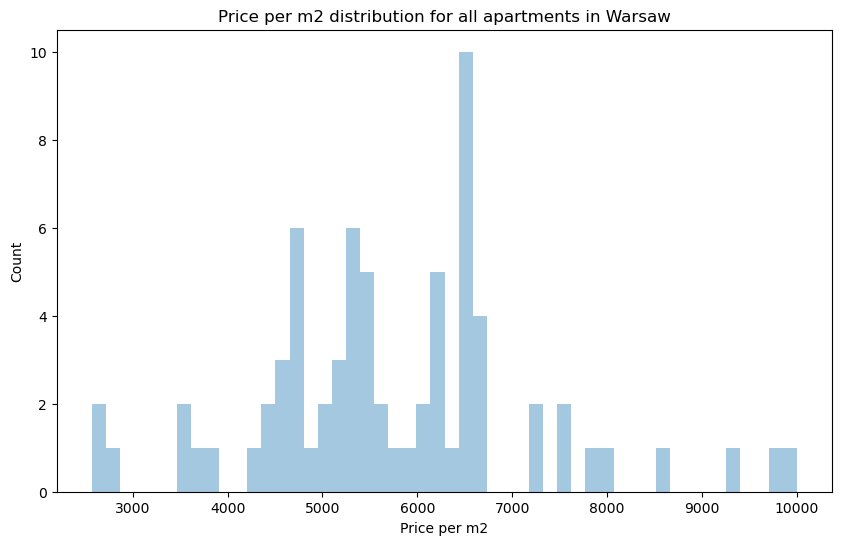

In [220]:
# plot price per m2 distribution for all apartments in Warsaw 
plt.figure(figsize=(10, 6))
sns.distplot(insights['price_per_m2'], bins=50, kde=False)
plt.title('Price per m2 distribution for all apartments in Warsaw')
plt.xlabel('Price per m2')
plt.ylabel('Count')
plt.show()

C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\946159346.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insights['price'], bins=50, kde=False)


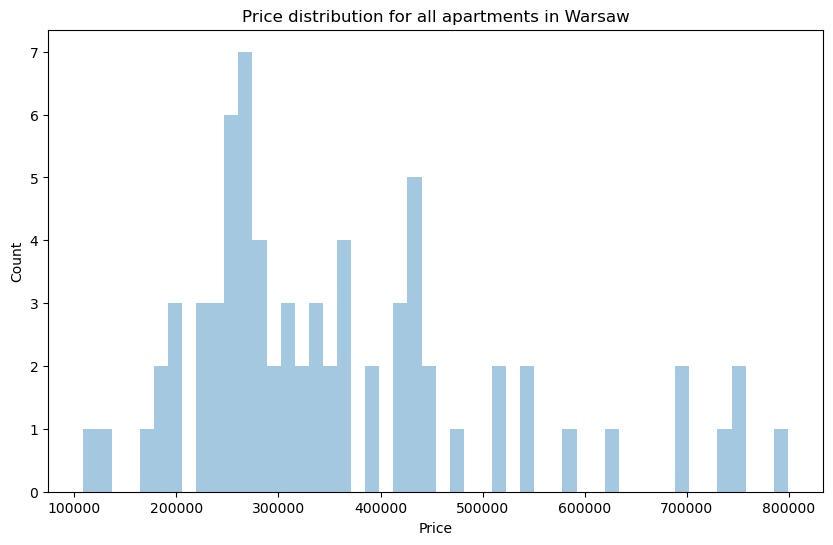

In [221]:
# plot price for all apartments in Warsaw and show price true values on xlabel
plt.figure(figsize=(10, 6))
sns.distplot(insights['price'], bins=50, kde=False)
plt.title('Price distribution for all apartments in Warsaw')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


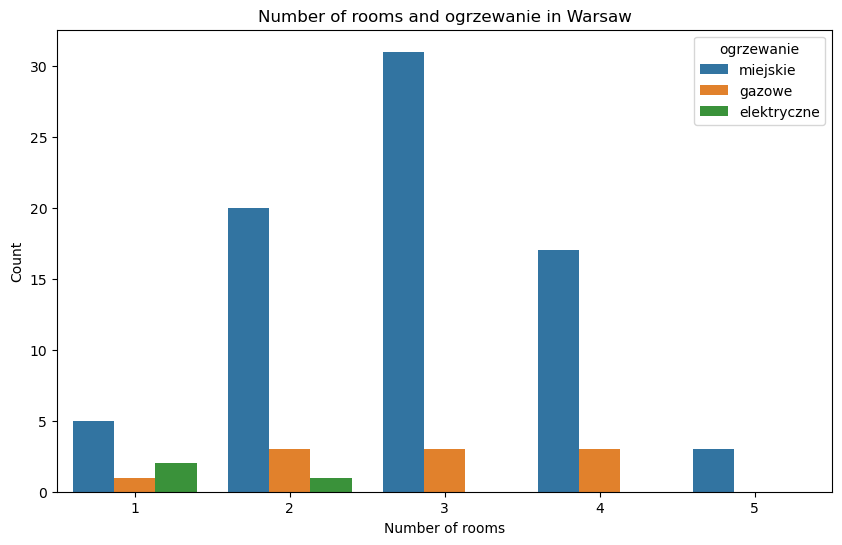

In [222]:
# compare number of rooms and ogrzewanie in Warsaw
plt.figure(figsize=(10, 6))
sns.countplot(x='rooms', hue='ogrzewanie', data=insights)
plt.title('Number of rooms and ogrzewanie in Warsaw')
plt.xlabel('Number of rooms')
plt.ylabel('Count')
plt.show()